In [1]:
import pandas as pd
import obspy
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import skew, kurtosis

# Paths for catalog and data directories
cat_directory = './data/lunar/training/catalogs/'
data_directory = './data/lunar/training/data/S12_GradeA/'  # Adjust this for Mars data if needed

# Load event catalog (replace 'apollo12_catalog_GradeA_final.csv' with your dataset's catalog)
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

In [3]:
# Function to plot a seismic event from the catalog
def plot_seismic_event(row):
    # Extract event details from the catalog row
    event_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    filename = row['filename']
    
    # Load CSV data for the event
    csv_file = f'{data_directory}{filename}.csv'
    data_cat = pd.read_csv(csv_file)
    
    # Extract relative times and velocity values
    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    # Plot the seismic trace
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data)
    ax.axvline(x=row['time_rel(sec)'], c='red', label='Arrival Time')
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'Event: {filename}', fontweight='bold')
    ax.legend()
    plt.show()

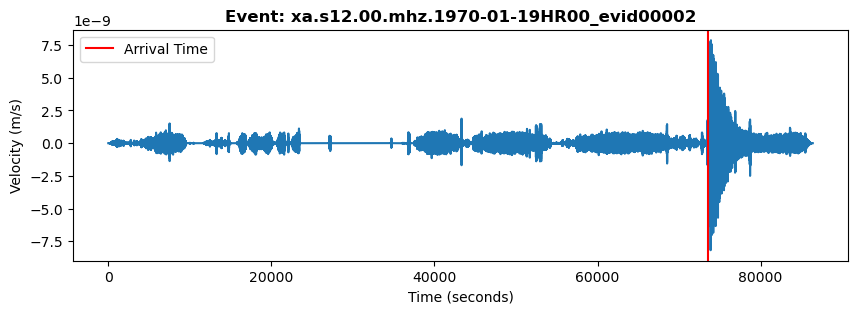

In [4]:
# Example: Plot the first event from the catalog
row = cat.iloc[0]
plot_seismic_event(row)

# Function to preprocess and filter seismic data
def preprocess_and_filter(trace, filter_min_freq=0.001, filter_max_freq=0.004, taper_pct=0.05):
    trace.detrend(type='linear')
    trace.taper(max_percentage=taper_pct, type='cosine')
    trace.filter('bandpass', freqmin=filter_min_freq, freqmax=filter_max_freq)
    return trace

# Function to extract features from the seismic event window
def extract_features_from_trace(trace, window_size=50, step_size=5):
    feature_matrix = []
    data = trace.data
    
    num_windows = (len(data) - window_size) // step_size + 1
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data[start:end]
        max_amp = np.max(window)
        min_amp = np.min(window)
        mean_amp = np.mean(window)
        window_skewness = skew(window, bias=False)
        window_kurtosis = kurtosis(window, bias=False)
        freq_data = np.abs(fft(window))
        mean_freq = np.mean(freq_data)
        max_freq = np.max(freq_data)
        peak_freq = np.argmax(freq_data)
        freq_variance = np.var(freq_data)
        
        feature_vector = [max_amp, min_amp, mean_amp, window_skewness, window_kurtosis, mean_freq, max_freq, peak_freq, freq_variance]
        feature_matrix.append(feature_vector)
    
    return np.array(feature_matrix)

In [5]:
# Example: Preprocess and extract features from the first event
file_path = f'{data_directory}{row["filename"]}.mseed'
stream = obspy.read(file_path)

# Apply preprocessing and filtering to the trace
for trace in stream:
    preprocessed_trace = preprocess_and_filter(trace)

    # Extract features
    features = extract_features_from_trace(preprocessed_trace)
    print(f"Extracted Features:\n{features}")

# Function to label traces based on a threshold
def label_trace(trace, threshold=1000):
    return 1 if np.max(trace.data) > threshold else 0

# Example: Label the preprocessed trace
label = label_trace(preprocessed_trace)
print(f"Label for the event: {label}")

Extracted Features:
[[ 0.00000000e+00 -3.08970738e-24 -4.68470928e-25 ...  2.34235464e-23
   0.00000000e+00  2.25488608e-47]
 [-6.23805147e-30 -5.51439949e-24 -9.13602213e-25 ...  4.56801107e-23
   0.00000000e+00  8.12261188e-47]
 [-2.99052364e-28 -9.35239031e-24 -1.68187824e-24 ...  8.40939122e-23
   0.00000000e+00  2.61316998e-46]
 ...
 [ 6.41831357e-13  6.28542458e-13  6.35190388e-13 ...  3.17595194e-11
   0.00000000e+00  1.97481960e-23]
 [ 6.40478123e-13  6.27185461e-13  6.33834197e-13 ...  3.16917099e-11
   0.00000000e+00  1.96639064e-23]
 [ 6.39123869e-13  6.25828761e-13  6.32477689e-13 ...  3.16238844e-11
   0.00000000e+00  1.95797795e-23]]
Label for the event: 0


In [ ]:
# Apply feature extraction and labeling to all events in the catalog
all_features = []
all_labels = []

for i, row in cat.iterrows():
    file_path = f'{data_directory}{row["filename"]}.mseed'
    
    try:
        # Try reading the seismic file
        stream = obspy.read(file_path)
        
        # Proceed with processing if the file is found
        for trace in stream:
            preprocessed_trace = preprocess_and_filter(trace)
            features = extract_features_from_trace(preprocessed_trace)
            
            if features.size > 0:
                label = label_trace(preprocessed_trace)
                all_features.extend(features)
                all_labels.extend([label] * len(features))
    
    except FileNotFoundError as e:
        print(f"File not found: {file_path}. Skipping this event.")


File not found: ./data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed. Skipping this event.


In [7]:
# Convert features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Train/test split and train a model as in your existing code
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.3, random_state=42)

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [8]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    686844

    accuracy                           1.00    686844
   macro avg       1.00      1.00      1.00    686844
weighted avg       1.00      1.00      1.00    686844

